# 🧠 NeuroGNN EEG Training Pipeline
Complete modular pipeline with K-Fold, preloading, and evaluation.

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, random
import matplotlib.pyplot as plt

In [70]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [82]:
class EEGGraphDataset(Dataset):
    def __init__(self, df, root_dir, adj_matrix, transform=None):
        self.df = df.reset_index()
        self.root_dir = root_dir
        self.adj_matrix = torch.tensor(adj_matrix, dtype=torch.long)
        self.edge_index = torch.nonzero(self.adj_matrix).t().contiguous()
        self.transform = transform

        self.signal_cache = {}
        for path in self.df['signals_path'].unique():
            full_path = os.path.join(root_dir, path)
            self.signal_cache[path] = pd.read_parquet(full_path).T

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        segment = self.signal_cache[row['signals_path']]
        start = int(row['start_time'] * row['sampling_rate'])
        end = int(row['end_time'] * row['sampling_rate'])

        segment_window = segment.iloc[:, start:end]
        mean = torch.tensor(segment_window.mean(axis=1).values, dtype=torch.float).unsqueeze(1)
        std = torch.tensor(segment_window.std(axis=1).values, dtype=torch.float).unsqueeze(1)
        max_ = torch.tensor(segment_window.max(axis=1).values, dtype=torch.float).unsqueeze(1)
        x = torch.cat([mean, std, max_], dim=1)

        y = torch.tensor(row['label'], dtype=torch.float)

        data = Data(x=x, edge_index=self.edge_index, y=y)
        return self.transform(data) if self.transform else data

In [83]:
def graph_sequence_collate(batch):
    batch_graph = Batch.from_data_list(batch)
    labels = torch.tensor([data.y.item() for data in batch])

    return batch_graph, labels


In [84]:
class NeuroGNN(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, batch):
        x, edge_index, batch_index = batch.x, batch.edge_index, batch.batch
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch_index)
        return self.lin(x)

In [85]:
def get_model(model_name, model_params, device):
    if model_name == "NeuroGNN":
        return NeuroGNN(**model_params).to(device)
    raise ValueError("Unsupported model")

def get_dataset(config):
    return EEGGraphDataset(
        df=config["train_df"],
        root_dir=config["root_dir"],
        adj_matrix=config["adj_matrix"]
    )

In [86]:
def train_one_fold(model, loader, device, config):
    y_all = [data.y.item() for data in loader.dataset]
    pos_count = sum(y_all)
    neg_count = len(y_all) - pos_count
    pos_weight = torch.tensor([neg_count / pos_count]).to(device)
    criterion = config["criterion_fn"](pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    model.train()
    for epoch in tqdm(range(config["num_epochs"]), desc="Epochs"):
        running_loss = 0.0
        for x_batch, y_batch in loader:
            y_batch = y_batch.float().unsqueeze(1).to(device)
            graph_seq = x_batch.to(device)
            logits = model(graph_seq)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return model

In [87]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            y_batch = y_batch.float().unsqueeze(1).to(device)
            graph_seq = x_batch.to(device)
            logits = model(graph_seq)
            probs = torch.sigmoid(logits).cpu().numpy()
            y_true.append(y_batch.cpu().numpy())
            y_probs.append(probs)

    y_true = np.concatenate(y_true).flatten()
    y_probs = np.concatenate(y_probs).flatten()
    best_th, best_f1 = 0.5, 0
    for th in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_probs > th).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th

    y_pred_final = (y_probs > best_th).astype(int)

    plt.hist(y_probs, bins=50)
    plt.title("Distribution des probabilités (sigmoid(logits))")
    plt.xlabel("Probabilité de crise")
    plt.ylabel("Fréquence")
    plt.grid()
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_true, y_pred_final),
        'precision': precision_score(y_true, y_pred_final, zero_division=0),
        'recall': recall_score(y_true, y_pred_final, zero_division=0),
        'f1_score': best_f1,
        'threshold': best_th
    }

In [93]:
from torch.utils.data import WeightedRandomSampler

def make_balanced_loader(dataset, batch_size):
    labels = [int(data.y.item()) for data in dataset]
    class_sample_count = np.bincount(labels)
    weights = 1. / class_sample_count
    sample_weights = [weights[int(label)] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, collate_fn=graph_sequence_collate)


In [94]:
def train_pipeline(config, device):
    seed_everything(42)
    dataset = get_dataset(config)
    y_all = [data.y.item() for data in dataset]

    kf = StratifiedKFold(n_splits=config["k_folds"], shuffle=True, random_state=42)
    all_metrics = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset, y_all)):
        print(f"\n===== Fold {fold + 1} =====")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = make_balanced_loader(train_subset, batch_size=config["batch_size"])
        val_loader = make_balanced_loader(val_subset, batch_size=config["batch_size"])
        model = get_model(config["model"], config["model_params"], device)
        model = train_one_fold(model, train_loader, device, config)
        metrics = evaluate_model(model, val_loader, device)
        print(f"Fold {fold + 1} Metrics:", metrics)
        all_metrics.append(metrics)
    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n=== Average Metrics Across Folds ===")
    print(avg_metrics)
    return model, avg_metrics

In [95]:
# Chargement des fichiers
train_df = pd.read_parquet("../data/train/segments.parquet")
distances_df = pd.read_csv("../data/distances_3d.csv", index_col=0)

# Transformation en matrice carrée
distances_df_square = distances_df.pivot_table(index='from', columns='to', values='distance')
distances_df_square = distances_df_square.astype(float)

# Construction d'une matrice d'adjacence (seuil ajustable)
def build_adjacency_matrix(distances_df, threshold=1.0):
    mat = distances_df.values
    adj = (mat < threshold).astype(int)
    np.fill_diagonal(adj, 0)
    return adj

adj_matrix = build_adjacency_matrix(distances_df_square)


In [96]:
config = {
    "model": "NeuroGNN",
    "model_params": {"in_channels": 3, "hidden_channels": 128},
    "batch_size": 32,
    "num_epochs": 5,
    "lr": 1e-3,
    "k_folds": 3,  # Pour test rapide. Mets 5 pour le vrai run.
    "criterion_fn": nn.BCEWithLogitsLoss,
    "root_dir": "../data/train",
    "train_df": train_df,
    "adj_matrix": adj_matrix
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



===== Fold 1 =====


Epochs: 100%|██████████| 5/5 [01:43<00:00, 20.76s/it]


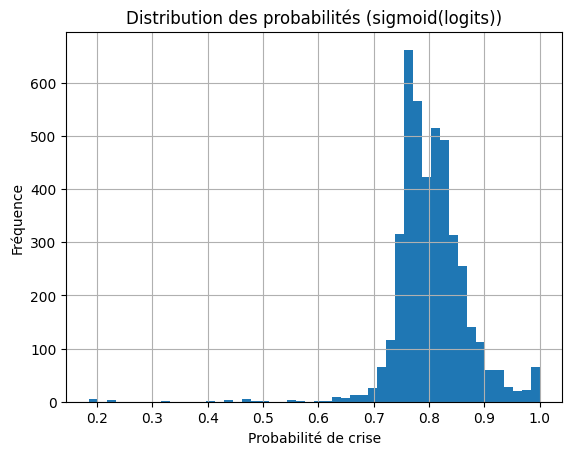

Fold 1 Metrics: {'accuracy': 0.4894943431078273, 'precision': 0.4894943431078273, 'recall': 1.0, 'f1_score': 0.6572624399317936, 'threshold': np.float64(0.1)}

===== Fold 2 =====


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
model, metrics = train_pipeline(config, device)
